<a href="https://colab.research.google.com/github/ArindamBanerji/wip-experiments/blob/master/nlp/ner_NER_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
tf.__version__

'2.10.1'

In [2]:
tfds.__version__

'4.7.0'

In [3]:
# for the time  being comment out this piece 

# import wget
url_download_from = "https://gmb.let.rug.nl/releases/gmb-2.2.0.zip"

# !wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip
# wget.download('Url', 'C:\\PathToMyDownloadFolder\\NewFileName.extension')
# wget.download(url_download_from, ".")

In [4]:
import os
import pathlib
import sys
import platform
import shutil
import pickle

In [5]:
IN_COLAB = 'google.colab' in sys.modules
FNAMES_SAVED = False
sys_name = platform.system()

print ("Runnig in Google Colab :", IN_COLAB, "\n", "on OS :", sys_name) 

Runnig in Google Colab : False 
 on OS : Windows


In [6]:
if (IN_COLAB) :
    ######## GPU CONFIGS FOR RTX 2070 ###############
    ## Please ignore if not training on GPU       ##
    ## this is important for running CuDNN on GPU ##

    tf.keras.backend.clear_session() #- for easy reset of notebook state

    # chck if GPU can be seen by TF
    tf.config.list_physical_devices('GPU')
    # only if you want to see how commands are executed, uncomment below
    # tf.debugging.set_log_device_placement(True)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
      except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
    ###############################################


In [7]:
if (IN_COLAB) :
    from google.colab import drive

In [8]:
if (IN_COLAB) :
    mount_base = "/content/drive/My Drive"
    # Load the Drive helper and mount
  # This will prompt for authorization.
    drive.mount('/content/drive')
    mount_path = "/content/drive/My Drive/NLP/NER_EXPTS"
    ner_dirnm = mount_path + "/"
else :
    mount_base = "C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects"
    mount_path = mount_base + "\\NLP\\NER_EXPTS"
    ner_dirnm = "G:\\My Drive\\NLP\\NER_EXPTS\\"

print (mount_path)
print (ner_dirnm)

C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\NLP\NER_EXPTS
G:\My Drive\NLP\NER_EXPTS\


In [9]:
path_exists = os.path.exists(mount_path)
ner_dir_exists = os.path.exists(ner_dirnm)

if path_exists : 
  print (mount_path, " : " , path_exists )
else:
  print ( "Load correct dir ", mount_path )

C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\NLP\NER_EXPTS  :  True


In [10]:
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir(mount_path)

# Print the current working directory
print("Changed working directory: {0}".format(os.getcwd()))

Current working directory: c:\Users\Arindam Banerji\CopyFolder\IoT_thoughts\python-projects\kaggle_experiments\wip_expts_v2\nlp
Changed working directory: C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\NLP\NER_EXPTS


In [11]:
data_root = './gmb-2.2.0/data/' if IN_COLAB == True else '.\\gmb-2.2.0\\data\\' 

print ( data_root) 

.\gmb-2.2.0\data\


In [12]:
fnames_list_fnm = ner_dirnm + "fnames_list.data"

In [13]:
def save_list_to_file ( fnames_list_fnm, fnames_list) :
        with open(fnames_list_fnm, 'wb') as filehandle:
            # Store the data as a binary data stream
            pickle.dump(fnames_list, filehandle)

In [14]:
def load_list_from_file ( fnames_list_fnm) :
    fnames_loaded = []
    if os.path.isfile(fnames_list_fnm) and os.access(fnames_list_fnm, os.R_OK) :
        with open(fnames_list_fnm, 'rb') as filehandle:
            # Read the data as a binary data stream
            fnames_loaded = pickle.load(filehandle)
    return fnames_loaded

In [15]:
# data_root = './gmb-2.2.0/data/'

fnames = []
data_root = './gmb-2.2.0/data/' if IN_COLAB == True else '.\\gmb-2.2.0\\data\\'
convert_to_posix = True if (IN_COLAB == False) and (sys_name == 'Windows') else False 

if os.path.isfile(fnames_list_fnm) and os.access(fnames_list_fnm, os.R_OK) :
    fnames = load_list_from_file (fnames_list_fnm)
else :
        for root, dirs, files in os.walk(data_root):
            for filename in files:
                if filename.endswith(".tags"):
                    pfn = os.path.join(root, filename)
                    pfn2 = pathlib.PureWindowsPath(pfn).as_posix() if convert_to_posix else pfn
                    fnames.append(pfn2)
        
        save_list_to_file (fnames_list_fnm, fnames)
        FNAMES_SAVED = True

In [16]:
if FNAMES_SAVED :
    fnames_reloaded = load_list_from_file (fnames_list_fnm)
    print ("Are fnames && fnames_reloaded equal : ", (fnames == fnames_reloaded) )
    print ("FNAMES were saved to  ", fnames_list_fnm)
else :
    print ("FNAMES were loaded from ", fnames_list_fnm)

Are fnames && fnames_reloaded equal :  True
FNAMES were saved to   G:\My Drive\NLP\NER_EXPTS\fnames_list.data


In [17]:
print (" num of files ", len(fnames) )
fnames[:2]

 num of files  10000


['gmb-2.2.0/data/p00/d0018/en.tags', 'gmb-2.2.0/data/p00/d0025/en.tags']

In [18]:
# save_list_to_file (fnames_list_fnm, fnames)
# fnames_loaded = load_list_from_file (fnames_list_fnm)
# print ("fnames is equal to fnames_loaded ", (fnames == fnames_loaded))

In [19]:
ner_path = "./ner"

ner_exists = os.path.exists(ner_path)
num_files_in_ner = 0

if ner_exists :
    onlyfiles = next(os.walk(ner_path))[2]
    num_files_in_ner = len(onlyfiles) 
    print ( len(onlyfiles) ) 
    shutil.rmtree(ner_path)
               
os.mkdir(ner_path)

print ("Directory status ", ner_path, " : ", os.path.exists(ner_path) )

10000
Directory status  ./ner  :  True


In [20]:
import csv
import collections
 
ner_tags = collections.Counter()
iob_tags = collections.Counter()

def strip_ner_subcat(tag):
    # NER tags are of form {cat}-{subcat}
    # eg tim-dow. We only want first part
    return tag.split("-")[0]


def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        iob_tags[token] += 1
    return iob_tokens  


In [ ]:
total_sentences = 0
outfiles = []
for idx, file in enumerate(fnames):
    with open(file, 'rb') as content:
        data = content.read().decode('utf-8').strip()
        sentences = data.split("\n\n")
        print(idx, file, len(sentences))
        total_sentences += len(sentences)
        
        with open("./ner/"+str(idx)+"-"+os.path.basename(file), 
                  'w', encoding='utf-8') as outfile:
            outfiles.append("./ner/"+str(idx)+"-"+os.path.basename(file))
            writer = csv.writer(outfile)
            
            for sentence in sentences: 
                toks = sentence.split('\n')
                words, pos, ner = [], [], []
                
                for tok in toks:
                    t = tok.split("\t")
                    words.append(t[0])
                    pos.append(t[1])
                    ner_tags[t[3]] += 1
                    ner.append(strip_ner_subcat(t[3]))
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)])

In [22]:
print("total number of sentences: ", total_sentences)

total number of sentences:  62010


In [23]:
print(" nertags : ", ner_tags, "\n")
print("iob tags ", iob_tags, "\n")

 nertags :  Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'per-mid': 1, 'art-add': 1}) 

iob tags  Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62}) 



In [24]:
import matplotlib.pyplot as plt

labels, values = zip(*iob_tags.items())

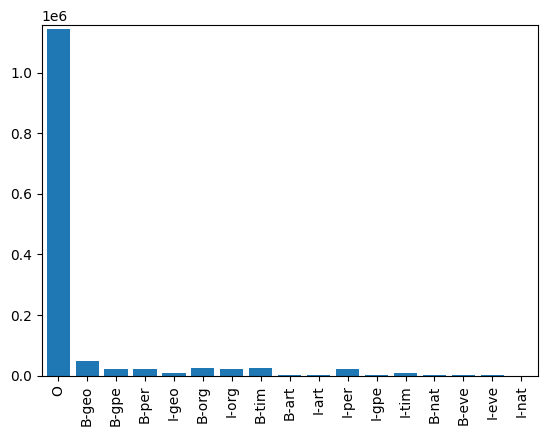

In [25]:
indexes = np.arange(len(labels))


plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [26]:
import glob
import pandas as pd

# could use `outfiles` param as well
files = glob.glob("./ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, 
                                 names=["text", "label", "pos"]) 
                for f in files], ignore_index = True)

In [27]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [29]:
data_pd.sample(10)

,text,label,pos
23974,"In his radio address Saturday , Thai Prime Min...",O O O O B-tim O B-gpe B-per I-per I-per I-per ...,"IN PRP$ NN NN NNP , JJ NNP NNP NNP NNP VBD IN ..."
29625,Officials say the thefts will not impact voter...,O O O O O O O O O O O B-tim I-tim I-tim I-tim ...,NNS VBP DT NNS MD RB VB NN NN VBN IN NNP CD CC...
307,Real estate and oil and gas companies are the ...,O O O O O O O O O O O O O O,JJ NN CC NN CC NN NNS VBP DT JJ RBS JJ NNS .
48997,Most economists say the U.S. housing market is...,O O O O B-geo O O O O O O O O O O O O O O O O O O,JJS NNS VBP DT NNP NN NN VBZ VBG RP IN VBG NN ...
15316,"Nevertheless , France today is one of the most...",O O B-geo B-tim O O O O O O O O O O O O O O O ...,"RB , NNP NN VBZ CD IN DT RBS JJ NNS IN DT NN C..."
16735,The global lender said the world economy could...,O O O O O O O O O O O O O O O,DT JJ NN VBD DT NN NN MD VB RB JJ IN CD NN .
45948,The deaths were part of a crackdown following ...,O O O O O O O O O O O O B-per O B-geo O,DT NNS VBD NN IN DT NN VBG DT NN NN IN NNP IN ...
45247,He serves as one of three judges on American I...,O O O O O O O O B-gpe O O O O O O O O O O O O O O,"PRP VBZ IN CD IN CD NNS IN JJ NNP , WDT PRP VB..."
12794,Producer Zulima Palacio has the story .,O B-per I-per O O O O,NNP NNP NNP VBZ DT NN .
26225,Somalia 's exiled Islamist opposition is rejec...,B-geo O O O O O O O O O O O O O O B-geo O B-tim O,NNP POS VBN NN NN VBZ VBG NN NNS IN DT NN WDT ...


In [30]:
### Keras tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
text_tok = Tokenizer(filters='[\\]^\t\n', lower=False,
                     split=' ', oov_token='<OOV>')

pos_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

ner_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

In [31]:
text_tok.fit_on_texts(data_pd['text'])
pos_tok.fit_on_texts(data_pd['pos'])
ner_tok.fit_on_texts(data_pd['label'])

In [32]:
ner_config = ner_tok.get_config()
text_config = text_tok.get_config()

In [33]:
print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"O": 1146068, "B-geo": 48876, "B-gpe": 20436, "B-per": 21984, "I-geo": 9512, "B-org": 26195, "I-org": 21899, "B-tim": 26296, "B-art": 503, "I-art": 364, "I-per": 22270, "I-tim": 8493, "B-eve": 391, "I-eve": 318, "I-gpe": 244, "B-nat": 238, "I-nat": 62}', 'word_docs': '{"B-geo": 31660, "O": 61999, "B-gpe": 16565, "B-per": 17499, "I-geo": 7738, "B-org": 20478, "I-org": 11011, "B-tim": 22345, "B-art": 425, "I-art": 207, "I-per": 13805, "I-tim": 5526, "I-eve": 201, "B-eve": 361, "I-gpe": 224, "I-nat": 50, "B-nat": 211}', 'index_docs': '{"3": 31660, "2": 61999, "9": 16565, "7": 17499, "10": 7738, "5": 20478, "8": 11011, "4": 22345, "12": 425, "14": 207, "6": 13805, "11": 5526, "15": 201, "13": 361, "16": 224, "18": 50, "17": 211}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

In [34]:
text_vocab = eval(text_config['index_word'])
ner_vocab = eval(ner_config['index_word'])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 39422
Unique NER tags in vocab: 18


In [35]:
x_tok = text_tok.texts_to_sequences(data_pd['text'])
y_tok = ner_tok.texts_to_sequences(data_pd['label'])

In [36]:
print(text_tok.sequences_to_texts([x_tok[1]]), data_pd['text'][1])
print(ner_tok.sequences_to_texts([y_tok[1]]), data_pd['label'][1])

['Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "'] Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
['O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O'] O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O


In [38]:
print(text_tok.sequences_to_texts([x_tok[2]]), data_pd['text'][2])
print(ner_tok.sequences_to_texts([y_tok[2]]), data_pd['label'][2])

['They marched from the Houses of Parliament to a rally in Hyde Park .'] They marched from the Houses of Parliament to a rally in Hyde Park .
['O O O O O O O O O O O B-geo I-geo O'] O O O O O O O O O O O B-geo I-geo O


In [39]:
# now, pad seqences to a maximum length
from tensorflow.keras.preprocessing import sequence

max_len = 50

x_pad = sequence.pad_sequences(x_tok, padding='post',
                              maxlen=max_len)
y_pad = sequence.pad_sequences(y_tok, padding='post',
                              maxlen=max_len)

In [40]:
print(x_pad.shape, y_pad.shape)

(62010, 50) (62010, 50)


In [41]:
text_tok.sequences_to_texts([x_pad[4]])

["The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"]

In [42]:
ner_tok.sequences_to_texts([y_pad[4]])

['O O O O O O O O O O O B-geo O O B-org I-org O O O B-gpe O O O B-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [43]:
num_classes = len(ner_vocab)+1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(62010, 50, 19)

In [44]:
# Length of the vocabulary 
vocab_size = len(text_vocab) + 1 

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense

dropout=0.2
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(units=rnn_units,
                           return_sequences=True,
                           dropout=dropout,  
                           kernel_initializer=tf.keras.initializers.he_normal())),
    TimeDistributed(Dense(rnn_units, activation='relu')),
    Dense(num_classes, activation="softmax")
  ])

  
  return model

In [45]:
model = build_model_bilstm(
                        vocab_size = vocab_size,
                        embedding_dim=embedding_dim,
                        rnn_units=rnn_units,
                        batch_size=BATCH_SIZE,
                        classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (90, None, 64)            2523072   
                                                                 
 bidirectional (Bidirectiona  (90, None, 200)          132000    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (90, None, 100)          20100     
 ibuted)                                                         
                                                                 
 dense_1 (Dense)             (90, None, 19)            1919      
                                                                 
Total params: 2,677,091
Trainable params: 2,677,091
Non-trainable params: 0
_________________________________________________________________


In [46]:
X = x_pad 

In [47]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = X[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = X[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]

In [48]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49590, 50) (49590, 50, 19)
(12420, 50) (12420, 50, 19)


In [50]:
num_epochs = 15 if IN_COLAB else 5
print (num_epochs)

5


In [49]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=num_epochs)

Epoch 1/5
551/551 [==============================] - 182s 306ms/step - loss: 0.1713 - accuracy: 0.9119
Epoch 2/5
551/551 [==============================] - 193s 351ms/step - loss: 0.0456 - accuracy: 0.9689
Epoch 3/5
551/551 [==============================] - 191s 346ms/step - loss: 0.0340 - accuracy: 0.9757
Epoch 4/5
551/551 [==============================] - 187s 340ms/step - loss: 0.0285 - accuracy: 0.9791
Epoch 5/5
551/551 [==============================] - 177s 321ms/step - loss: 0.0243 - accuracy: 0.9819


In [51]:
# batch size in eval
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 23s 139ms/step - loss: 0.0539 - accuracy: 0.9665


[0.05386272445321083, 0.966489851474762]

In [52]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 23s 133ms/step


In [53]:
text_tok.sequences_to_texts([X_test[4]])

["The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"]

In [54]:
ner_tok.sequences_to_texts([y_pad[4]])

['O O O O O O O O O O O B-geo O O B-org I-org O O O B-gpe O O O B-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [55]:
y_pred = tf.argmax(y_pred, -1)
y_pred.shape

TensorShape([12420, 50])

In [56]:
y_pnp = y_pred.numpy()

In [57]:
ner_tok.sequences_to_texts([y_pnp[4]])

['O O O O O O O O O O O B-geo O O O O O O O B-eve O O O B-geo O O O O O O O O O O O O O O O O O O O O O O O O O O']